# Analysis of (Haber et al.)

We want to re-analyze the data from [*Haber et al. [2017]*](https://www.nature.com/articles/nature24489). 
The dataset contains cell compositions of the intestinal epithelium of mice under 4 conditions
(control, Salmonella infection, H. polygyrus infection (3 days), and H. polygyrus infection (10 days)).

In the original paper, differential abundance was tested via a Poisson regression model, 
not taking compositional effects into account.
We want to analyze whether the findings are consistent with SCDCdm.

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scdcdm.util import comp_ana as mod
from scdcdm.util import cell_composition_data as dat

Load and format data: 

4 control samples, 2 samples for other conditions each; 8 cell types

In [2]:
cell_counts = pd.read_csv("../data/haber_counts.csv")

cell_counts["Condition"] = cell_counts["Mouse"].str.replace(r"_[0-9]", "")
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse", "Condition"])

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft     Condition  
0  125       191    18       Control  
1   11        40     5       C

Plot data for supplement:
Goblet cells seem like a good baseline for Salmonella (not much change)
For H. Polygyrus, take TA cells

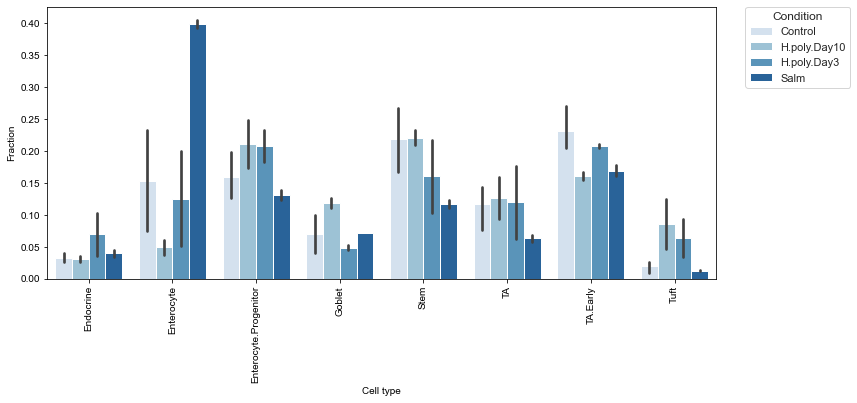

In [3]:
# Count data to ratios
counts = cell_counts.iloc[:, 1:-1]
rowsum = np.sum(counts, axis=1)

ratios = counts.div(rowsum, axis=0)
ratios["Condition"] = cell_counts["Condition"]

# Plot
fig, ax = plt.subplots(figsize=(12,5))
df = pd.melt(ratios, id_vars=['Condition'], value_vars=ratios.columns[:-1])
sns.set_context('notebook')
sns.set_style('ticks')
d = sns.barplot(x='variable', y = 'value', hue="Condition", data=df, palette="Blues")
d.set_ylabel('Fraction')
loc, labels = plt.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')
plt.legend(bbox_to_anchor=(1.2, 1), borderaxespad=0., title="Condition")

plot_path = "C:\\Users\\Johannes\\Documents\\Uni\\Master's_Thesis\\SCDCdm\\data\\benchmark_results\\"
plt.savefig(plot_path + "haber_bars_blue.svg", format="svg", bbox_inches="tight")
plt.savefig(plot_path + "haber_bars_blue.png", format="png", bbox_inches="tight")

plt.show()

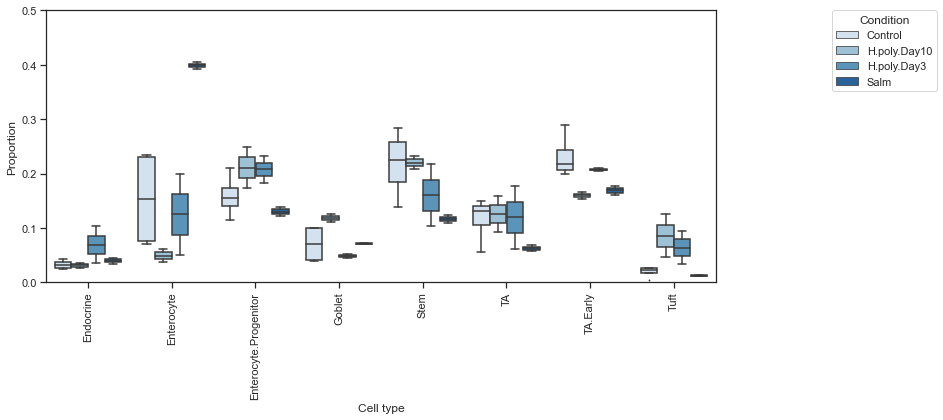

In [7]:
# Boxplots look a little better
fig, ax = plt.subplots(figsize=(12,5))
d = sns.boxplot(x='variable', y = 'value', hue=df["Condition"], data=df, fliersize=1,
               palette='Blues')

d.set_ylabel('Proportion')
loc, labels = plt.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')
d.set_ylim([0,0.5])
plt.legend(bbox_to_anchor=(1.33, 1), borderaxespad=0., title="Condition")

plt.savefig(plot_path + "haber_boxes_blue.svg", format="svg", bbox_inches="tight")
plt.savefig(plot_path + "haber_boxes_blue.png", format="png", bbox_inches="tight")

plt.show()

Apply SCDCdm to Salmonella (baseline: Goblet cells)

--> Only Enterocytes are significant 

--> Haber et al: Enterocytes, Stem, TA, and TA (early) cells change

In [5]:
# model Salmonella
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]

model_salmonella = mod.CompositionalAnalysis(data_salm, formula="Condition", baseline_index="Goblet")
results_salmonella = model_salmonella.sample_hmc()

MCMC sampling finished. (188.231 sec)
Acceptance rate: 47.9%


In [8]:
results_salmonella.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Baseline index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.061        33.569993
Enterocyte                       2.296       115.426344
Enterocyte.Progenitor            2.499       141.405636
Goblet                           1.733        65.735073
Stem                             2.674       168.448929
TA                               2.085        93.469260
TA.Early                         2.844       199.663333
Tuft                             0.397        17.281432


Effects:
                                         Final Parameter  Expected Sample  \
Covariate         Cell Type                                                 
Condition[T.Salm] Endocrine                     0.000000        23.497788   
                  Enterocyte                    1.411191       331.324310   
        

Apply SCDCdm to H. Polygyrus 3 days (baseline: TA cells)

--> No significant changes in cell composition

--> Haber et al: Tuft cells change

In [9]:
# model H. polygyrus day 3
data_hp3 = data_all[data_all.obs["Condition"].isin(["Control", "H.poly.Day3"])]

model_hp3 = mod.CompositionalAnalysis(data_hp3, formula="Condition", baseline_index="TA")
results_hp3 = model_hp3.sample_hmc()

MCMC sampling finished. (238.644 sec)
Acceptance rate: 48.0%


In [10]:
results_hp3.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Baseline index: 5
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.698        41.112200
Enterocyte                       1.734       115.851004
Enterocyte.Progenitor            2.033       156.226193
Goblet                           1.051        58.516275
Stem                             2.180       180.965230
TA                               1.643       105.774018
TA.Early                         2.318       207.743660
Tuft                             0.289        27.311420


Effects:
                                                Final Parameter  \
Covariate                Cell Type                                
Condition[T.H.poly.Day3] Endocrine                          0.0   
                         Enterocyte                         0.0   
                         Enterocyte.Progenitor  

Apply SCDCdm to H. Polygyrus 10 days (baseline: TA cells)

--> Enterocytes and Tuft cells are significant 

--> Haber et al: Enterocytes, Goblet, Tuft, and TA (early) cells change

In [13]:
# model H. polygyrus day 10
data_hp10 = data_all[data_all.obs["Condition"].isin(["Control", "H.poly.Day10"])]

model_hp10 = mod.CompositionalAnalysis(data_hp10, formula="Condition", baseline_index="TA")
results_hp10 = model_hp10.sample_hmc()

MCMC sampling finished. (179.790 sec)
Acceptance rate: 65.7%


In [14]:
results_hp10.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Baseline index: 5
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.722        37.769397
Enterocyte                       1.853       117.038058
Enterocyte.Progenitor            2.241       172.517584
Goblet                           1.426        76.363067
Stem                             2.469       216.696805
TA                               1.902       122.915751
TA.Early                         2.486       220.412142
Tuft                             0.427        28.120509


Effects:
                                                 Final Parameter  \
Covariate                 Cell Type                                
Condition[T.H.poly.Day10] Endocrine                     0.000000   
                          Enterocyte                   -0.741428   
                          Enterocyte.Progeni